In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [86]:
# Getting path from remote server (DigitalOcean Droplet)
import os
os.getcwd()

'/home/jonas'

In [87]:
# Importing files and merging them into one big dataset

train = pd.read_csv('Pycharmprojects/HelloFoodFreak/data/train.csv')
warehouses = pd.read_csv('Pycharmprojects/HelloFoodFreak/data/fulfilment_center_info.csv')
meals = pd.read_csv('Pycharmprojects/HelloFoodFreak/data/meal_info.csv')

merge_1 = train.merge(warehouses, on='center_id')
df = merge_1.merge(meals, on='meal_id')

df.set_index('id', inplace=True)

In [88]:
# First some basic exploration of the full dataset

print(df.head().T,'\n')
df.describe().T


id                       1379560    1018704    1196273    1116527    1343872
week                           1          2          3          4          5
center_id                     55         55         55         55         55
meal_id                     1885       1885       1885       1885       1885
checkout_price            136.83     135.83     132.92     135.86      146.5
base_price                152.29     152.29     133.92     134.86      147.5
emailer_for_promotion          0          0          0          0          0
homepage_featured              0          0          0          0          0
num_orders                   177        323         96        163        215
city_code                    647        647        647        647        647
region_code                   56         56         56         56         56
center_type               TYPE_C     TYPE_C     TYPE_C     TYPE_C     TYPE_C
op_area                        2          2          2          2          2

,count,mean,std,min,25%,50%,75%,max
week,456548.0,74.768771,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,82.105796,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2024.337458,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,332.238933,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,354.156627,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,0.081152,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,0.109200,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,261.872760,395.922798,13.00,54.00,136.00,324.00,24299.00
city_code,456548.0,601.553399,66.195914,456.00,553.00,596.00,651.00,713.00
region_code,456548.0,56.614566,17.641306,23.00,34.00,56.00,77.00,93.00


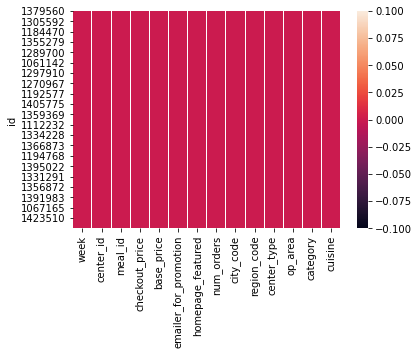

In [89]:
# Yay, no Null-values
sns.heatmap(df.isnull())

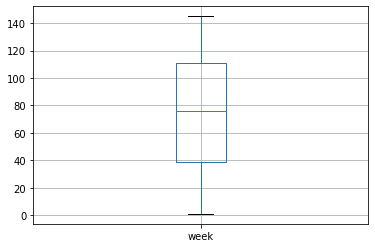

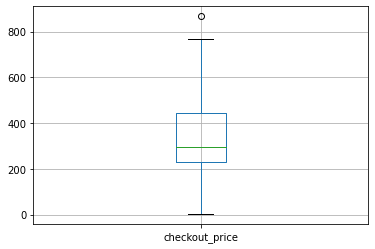

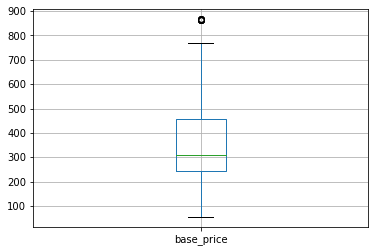

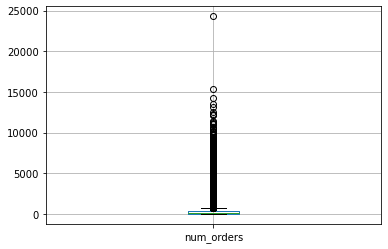

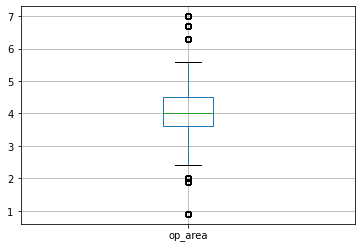

In [90]:
nominal_cols = ['center_id', 'meal_id', 'emailer_for_promotion','homepage_featured'] \
               + ['city_code', 'region_code','center_type'] \
               + ['category','cuisine']
# Outliers seem quite ok, except for num_orders, which seems to have many. Needs further exploration
for column in df.columns.drop(nominal_cols):
    plt.figure()
    df.boxplot(column = column,)

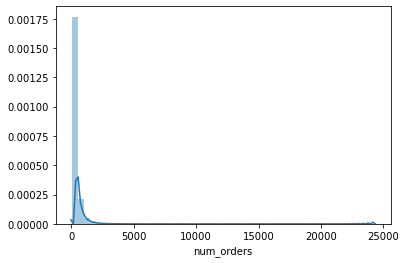

In [91]:
'''
Very right-tailed distribution. In a real case I would contact domain knowledge experts 
to check if this result is within expected range, also: I would probably already know 
more myself because normally you would not skip over the EDA as I've done here. 
'''

sns.distplot(df['num_orders'])



In [92]:
print(df.dtypes)


df = pd.get_dummies(data= df, columns=nominal_cols)

week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
category                  object
cuisine                   object
dtype: object


In [93]:
'''
Would of course never do this in a real production environment.
For almost 500k records I would most certainly use Spark instead of Pandas but
that is out of scope for this quick and dirty AI-project

Did run it on the full dataset on my own server, and got r2 values of 85 for
the Random Forrest and even 88 for the GBR!

Played around with the samplesize a bit and 40k seemed to be the best middle road of
getting decent results and not pushing your (local) machines too much.
'''

df = df.sample(50000, random_state=0)

In [94]:
X = df.drop('num_orders',axis=1)
y = df['num_orders']


In [95]:
'''
Yay, the fun stuff can begin: lets first train a dummymodel 
and see how much we can improve on that.
'''

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
dummy_median = DummyRegressor(strategy='mean')
dummy_regressor = dummy_median.fit(X_train,y_train)
dummy_predicts = dummy_regressor.predict(X_test)
print("Model Accuracy:", dummy_regressor.score(X_test,y_test)*100)
print('$',mean_absolute_error(y_test,dummy_predicts))

Model Accuracy: -0.07737487864414305
$ 234.90314655000003


In [96]:
'''
Defining the real models and giving them some parameters I know might work. 
Again not in the scope of this project but in a real life situation I would play
around a bit with these parameters and iterate until satisfied with the results.

Put on verbose if you want to follow along.
'''

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [DecisionTreeRegressor(criterion='mse',max_depth=11),
          GradientBoostingRegressor(n_estimators= 200,max_depth=12, verbose=0),
            RandomForestRegressor(min_samples_leaf = 1, n_estimators=100,criterion='mse',max_depth=20,verbose=0)]
learning_mods = pd.DataFrame()
temp = {}

DecisionTreeRegressor(max_depth=11)
score on training 0.8413226279087904
r2 score 0.6687369541604612 

GradientBoostingRegressor(max_depth=12, n_estimators=200)
score on training 0.9897059160664938
r2 score 0.7964840308868092 

RandomForestRegressor(max_depth=20)
score on training 0.958118949060462
r2 score 0.7858457054765148 



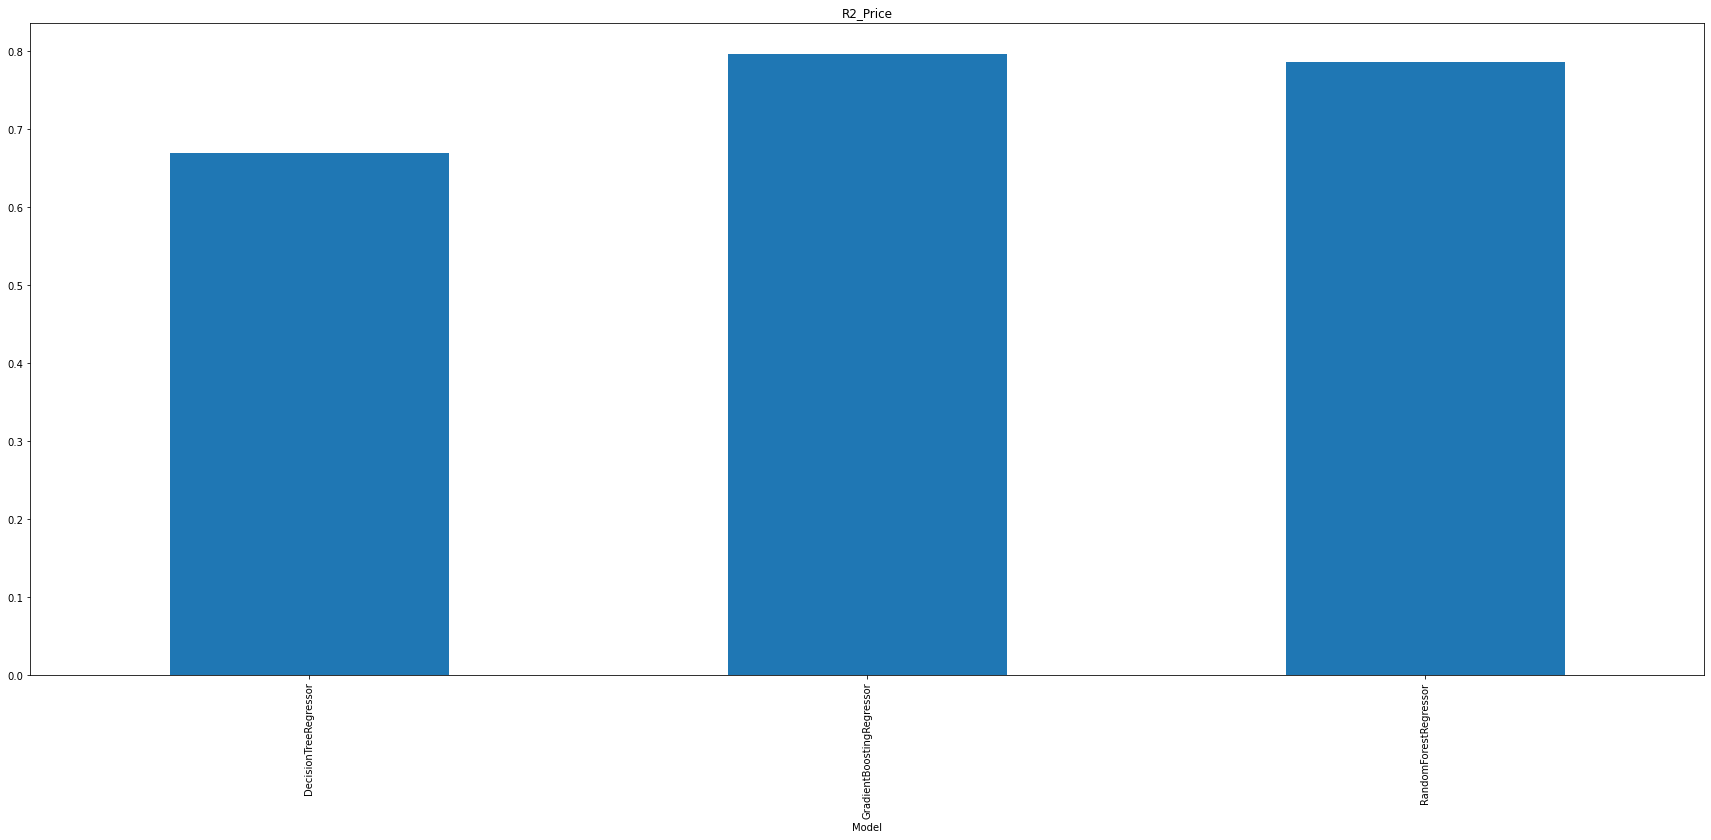

In [97]:
#run through models and plotting the results 
for model in models:
    print(model)
    m = str(model)
    temp['Model'] = m[:m.index('(')]
    model.fit(X_train, y_train)
    temp['R2_Price'] = r2_score(y_test, model.predict(X_test))
    print('score on training',model.score(X_train, y_train))
    print('r2 score',r2_score(y_test, model.predict(X_test)),'\n')
    learning_mods = learning_mods.append([temp])
learning_mods.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(30, 12))
learning_mods.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()

Great results! Being able to explain almost 80% of the variance in this dataset is awesome, we are even able to reach 88% when trained on all the rows instead of on a sample.

Although it has to be said that what we are doing is a bit stupid: we are not forecasting demand but only historic sales, which has little practical business value.


In [98]:
# Getting- and saving the feature importances of the last trained model

importances = model.feature_importances_
indices = np.argsort(importances)

features = df.columns.drop('num_orders')
data_tuples = list(zip(features,importances.tolist()))
features_importance = pd.DataFrame(data_tuples, columns=['Feature','Value'])

features_importance.to_csv('features_importance.csv')

NameError: name 'std' is not defined

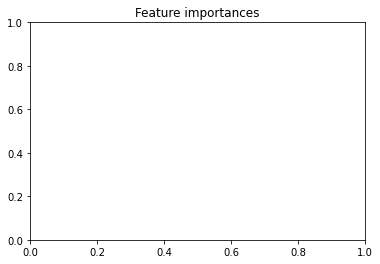

In [99]:
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()


In [ ]:
'''
Dropping features that don't explain enough of the variation. In a later phase we might
opt to retrain our models now only using the n-most important features. But again: 
out of scope.
'''

print(len(features_importance))
unimportant_features = features_importance[features_importance['Value'] < .01]
features_importance = features_importance[features_importance['Value'] > .01]
print(len(features_importance))

## Future improvements

- Hyperparameter optimization (eg. via Gridsearch)
- Feature Engineering using Domain Knowledge and Publicly available Data
- Starting with a decent EDA instead of just quickly cleaning and throwing it into some algorithm's
- More careful selection of training algoritmns, instead of quasi arbitrarily choosing 3 and see what sticks best looking at computation time and performance
- Dimensionality reduction (eg. via PCA)
- Only training on the strongest features? 

